<a href="https://colab.research.google.com/github/credwood/SportsBot/blob/master/sportsbot_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter conversation fine-tuning and zero-shot transfer testing with Yelp-2

All of the data for reproducibility provided [here](https://github.com/credwood/SportsBot). 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this demo, the sportsbot repository is in a directory called 'projects'

In [2]:
cd /content/drive/My Drive/projects/SportsBot/

/content/drive/My Drive/projects/SportsBot


Click 'restart' at the end of the requirements installation process in next cell and run cells above again (requires an newer matplotlib version which requires a system restart to replace Colab's deffault version)

In [ ]:
! pip install -r requirements.txt

In [4]:
from sportsbot.finetune import train, tokenize_data, pil_grid, autolabel, predict

In [5]:
cd /content/drive/My Drive/projects

/content/drive/My Drive/projects


In [6]:
import json
from sportsbot.datasets import read_data

#this labels dict is the same as the default version used by the code
label_dict = {"all_values": {
                  1: " No", 
                  2: " Remote", 
                  3: " Unsure", 
                  4: " Probably", 
                  5: " Yes", 
                  6: " Neutral", 
                  7: " None",
                  8: " Positive",
                  9: " Defensive",
                  10: " Negative",
                  11: " Opposition",
                  12: " Discussion",
                  13: " Agreement"
              },
              "bucketed_labels":{
                  1: [" No", " Remote"],
                  2: [" No", " Remote"], 
                  3: [" Unsure"], 
                  4: [" Probably", " Yes"],
                  5: [" Probably"," Yes"] ,
                  6: [" Neutral", " None"],
                  7: [" None", " Neutral"],
                  8: [" Positive"],
                  9: [" Defensive"],
                  10: [" Negative"],
                  11: [" Opposition",],
                  12: [" Discussion"],
                  13: [" Agreement"],
                  
              },
              "baseline_accuracy": 0.333
}

conv_objs = []
#conv_objs += read_data('data/multi_labeled_split_datasets/labeled_question_1_train.jsonl')
conv_objs += read_data('data/multi_labeled_split_datasets/labeled_question_2_train.jsonl')
#conv_objs += read_data('data/multi_labeled_split_datasets/labeled_question_3_train.jsonl')
#conv_objs += read_data('data/multi_labeled_split_datasets/labeled_question_4_train.jsonl')
#conv_objs += read_data('data/multi_labeled_split_datasets/labeled_question_5_train.jsonl')


In [7]:
filtered_objs =[]
for conv in conv_objs:
  if conv.label[1] == 8 or conv.label[1] == 10 or conv.label[1] == 6:
    filtered_objs.append(conv)

In [8]:
len(filtered_objs)

704

In [9]:
templates = []
answers = []

The path to the labeled data will be slightly different if you've cloned the sportsbot repository. It's in the 'multi_labeled_split_datasets' directory at the beginning of the path.

In [10]:
validate_objs = []
#validate_objs += read_data('data/multi_labeled_split_datasets/question_1_validate.jsonl')
validate_objs += read_data('data/multi_labeled_split_datasets/question_2_validate.jsonl')
#validate_objs += read_data('data/multi_labeled_split_datasets/question_3_validate.jsonl')
#validate_objs += read_data('data/multi_labeled_split_datasets/question_4_validate.jsonl')
#validate_objs += read_data('data/multi_labeled_split_datasets/question_5_validate.jsonl')
validate_objs[99].label = [3, 7, 12, 1, 1, ' the Lakers']

for conv in validate_objs:
  if conv.label[1] == 8 or conv.label[1] == 10 or conv.label[1] == 6:
    templates.append(conv)
    answers.append(conv.label[1])


In [11]:
len(templates)

81

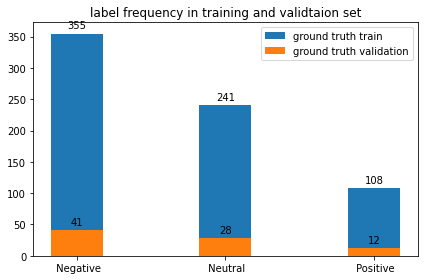

In [ ]:
%matplotlib notebook
%matplotlib inline
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np



fig, ax = plt.subplots(tight_layout=True)
width = 0.35
ground_trth_train = [label_dict["all_values"][filtered_objs[index].label[1]] for index in range(len(filtered_objs))]
ground_trth_train = Counter(ground_trth_train)
labels = list(ground_trth_train.keys())
x_ax = np.arange(len(labels))
ground_trth_train = [ground_trth_train[val] for val in sorted(ground_trth_train.keys())]
bar_grph_train = ax.bar(x_ax, ground_trth_train, width, label='ground truth train')
ground_trth_test = [label_dict["all_values"][answers[index]] for index in range(len(answers))]
ground_trth_test = Counter(ground_trth_test)
ground_trth_test = [ground_trth_test[val] for val in sorted(ground_trth_test.keys())]
bar_grph_test = ax.bar(x_ax, ground_trth_test, width, label='ground truth validation')
ax.set_title("label frequency in training and validtaion set")
ax.set_xticks(x_ax)
ax.set_xticklabels(sorted(labels))

autolabel(bar_grph_train, ax)
autolabel(bar_grph_test, ax)
ax.legend()
plt.show()

# Fine-tuning code: Balanced Q2 labels

In [12]:
import random

random.seed(10)

end = 355
pos_start = 108*3
neut_start = 241
temp_pos = []
temp_neut = []
temp_neg = []
train_objs = []
for conv in filtered_objs:
  if conv.label[1] == 8:
    temp_pos.append(conv)
  if conv.label[1] == 6:
    temp_neut.append(conv)
  if conv.label[1] == 10:
    temp_neg.append(conv)

temp_pos += temp_pos + temp_pos + temp_pos[:end-pos_start]
temp_neut += temp_neut[:end-neut_start]
#temp_pos += random.sample(temp_pos, k=end-pos_start)
#temp_neut += random.sample(temp_neut, k=end-neut_start)


train_objs += temp_pos + temp_neut + temp_neg
random.shuffle(train_objs)
len(train_objs)

1065

## Fine-tuning loop

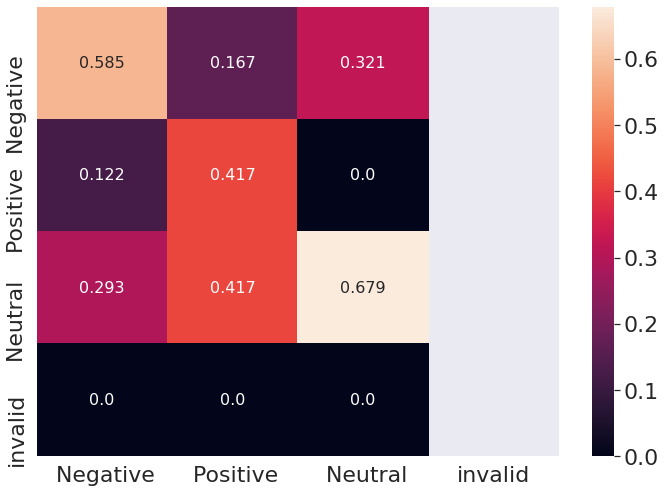

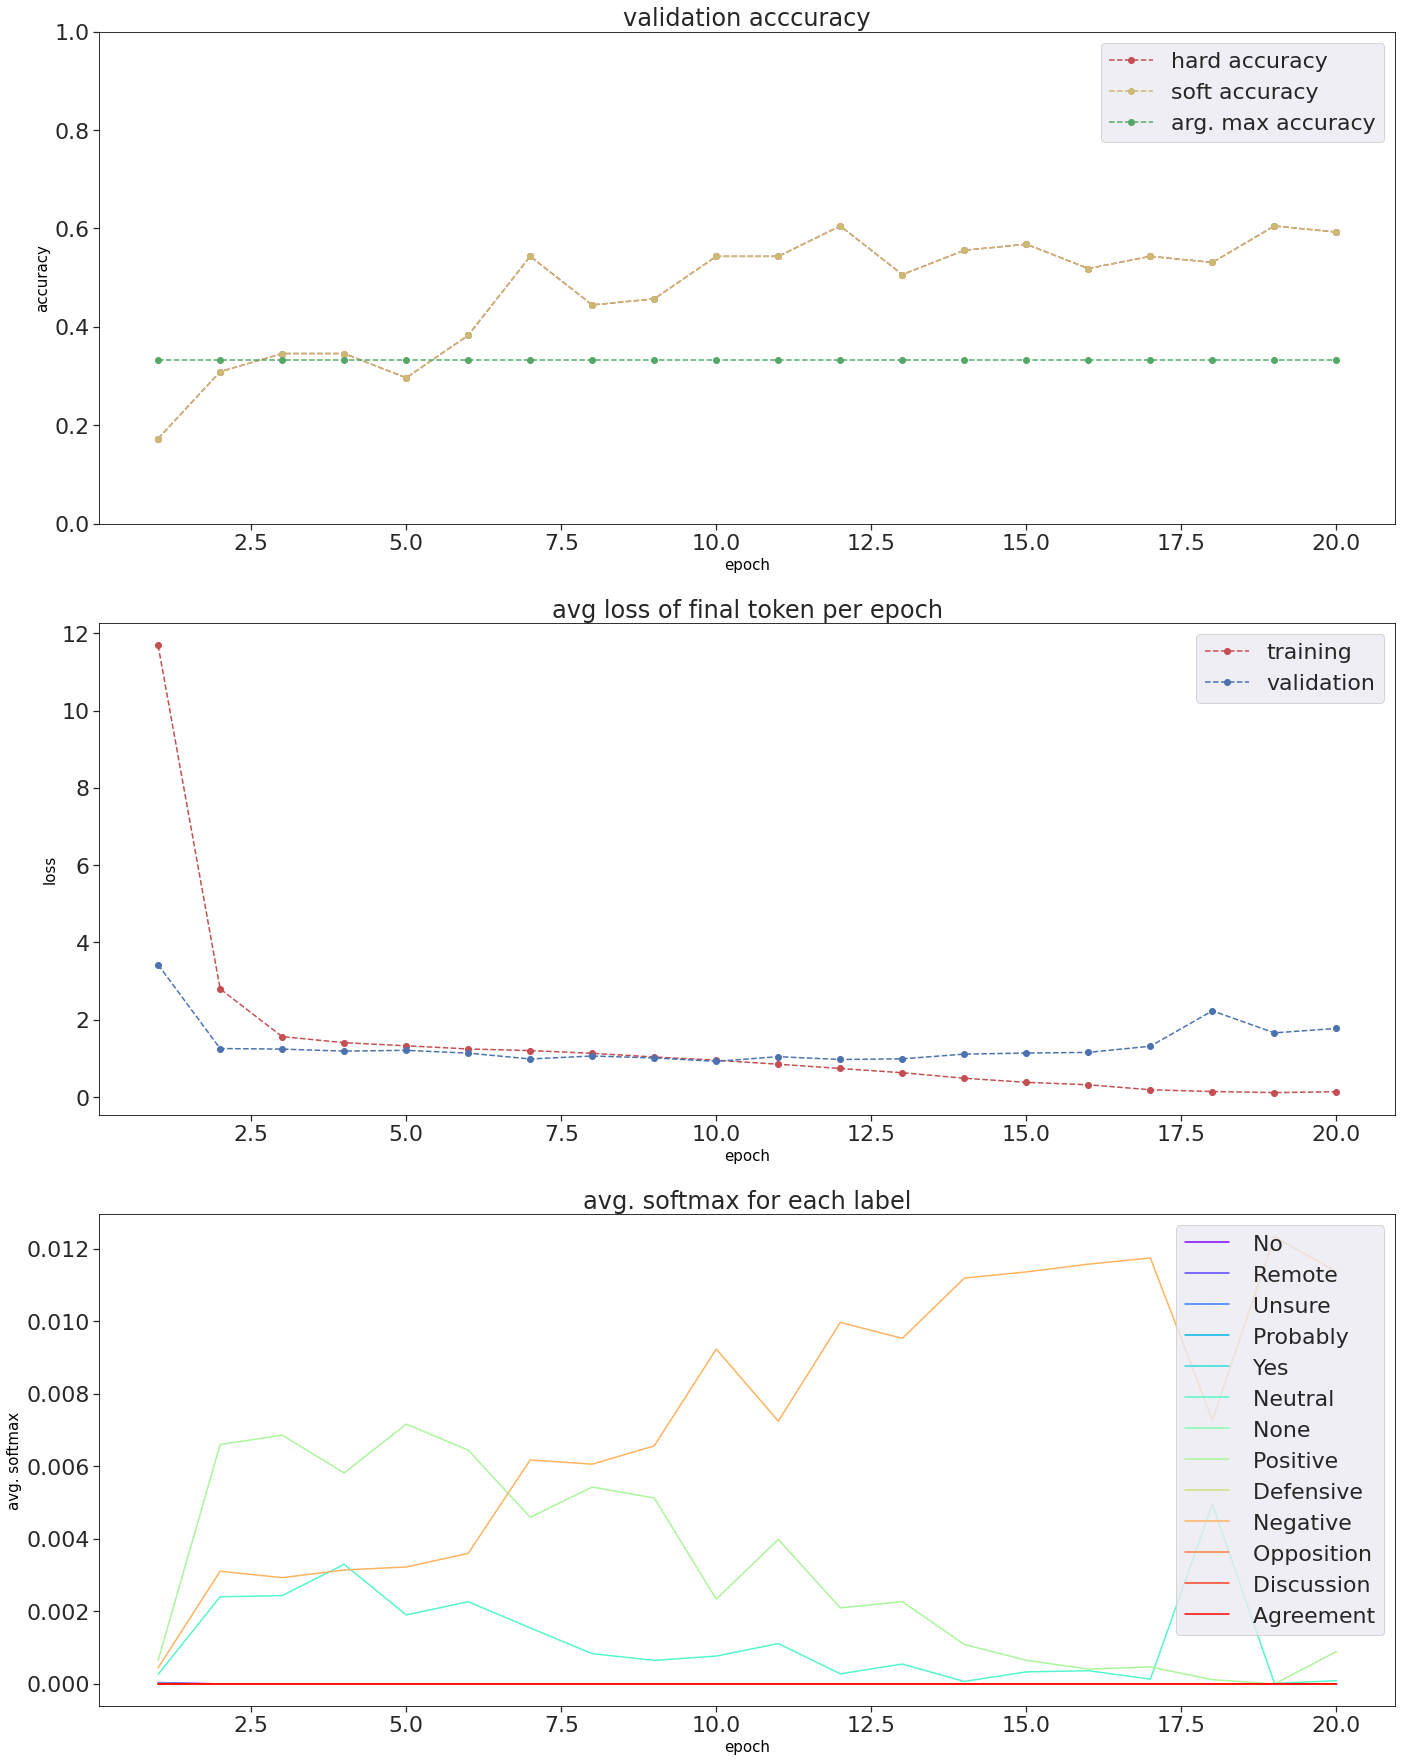

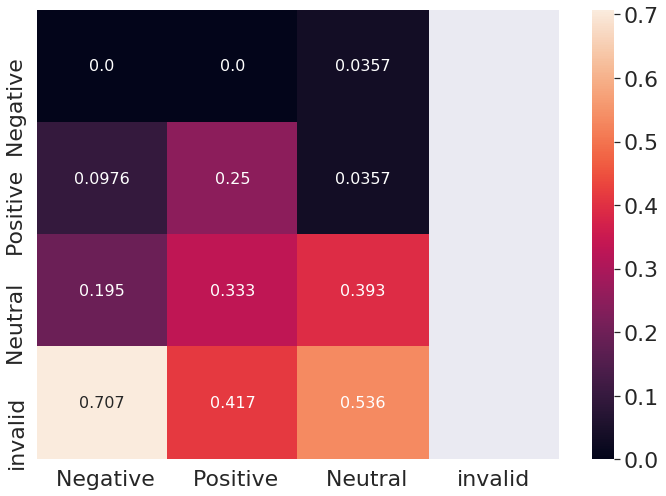

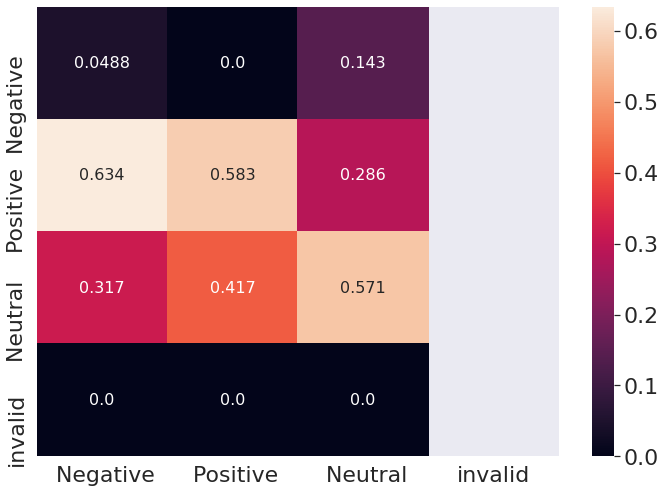

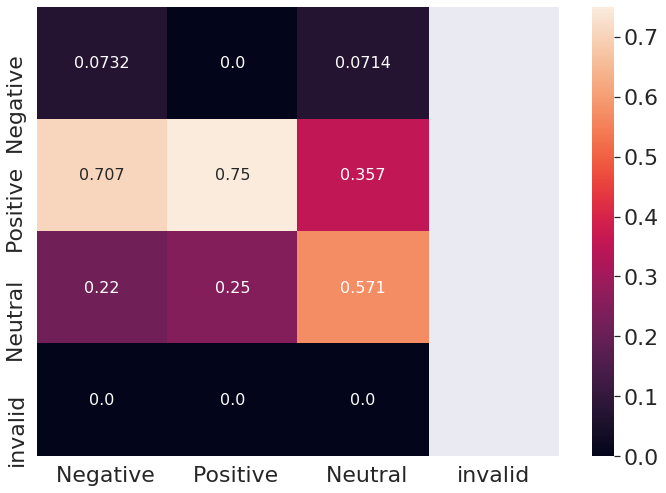

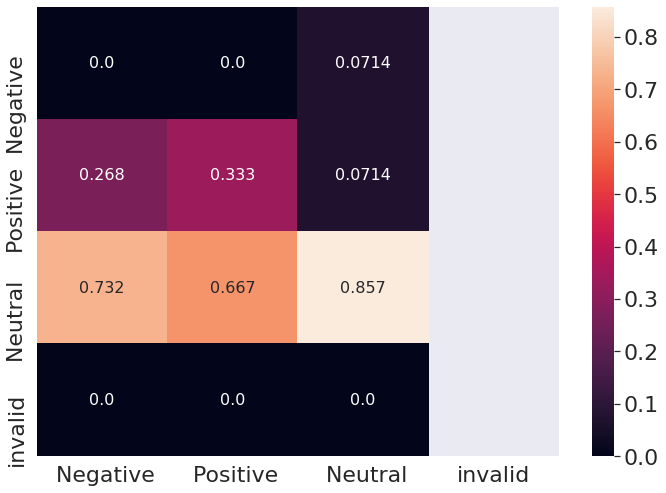

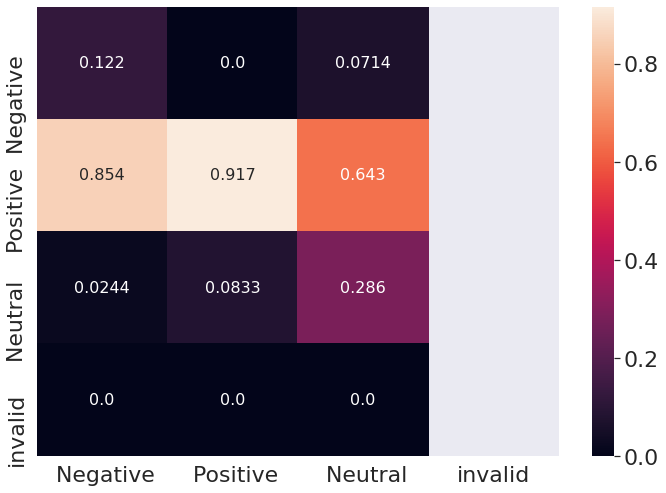

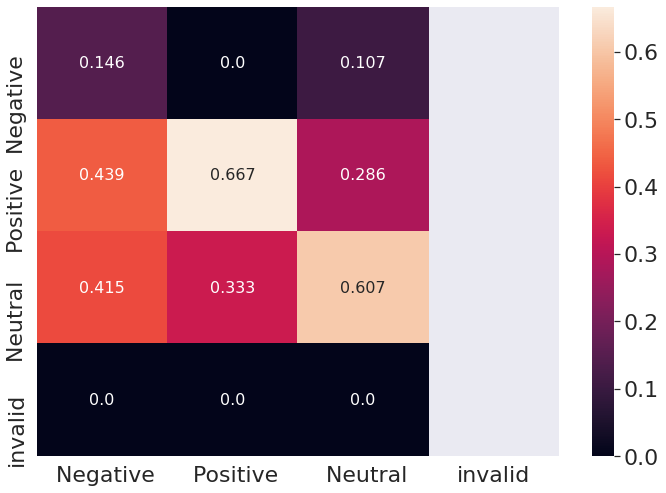

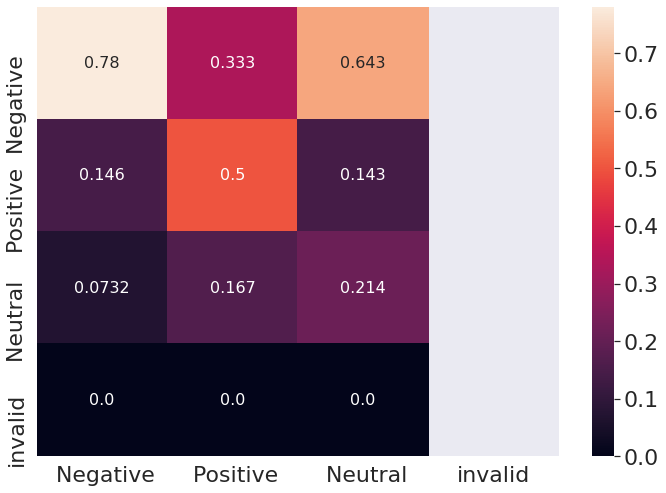

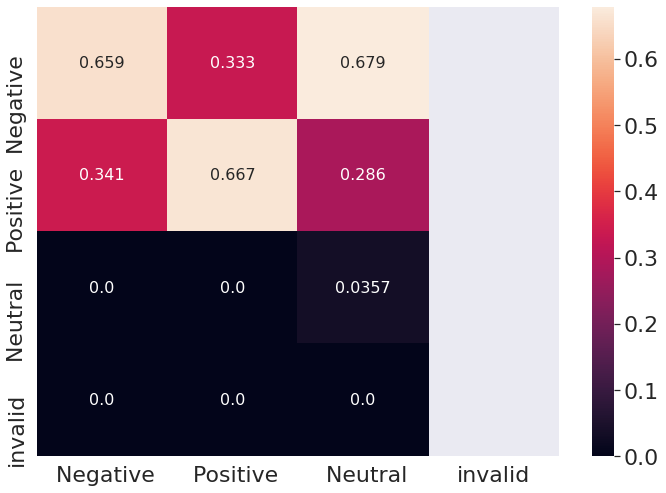

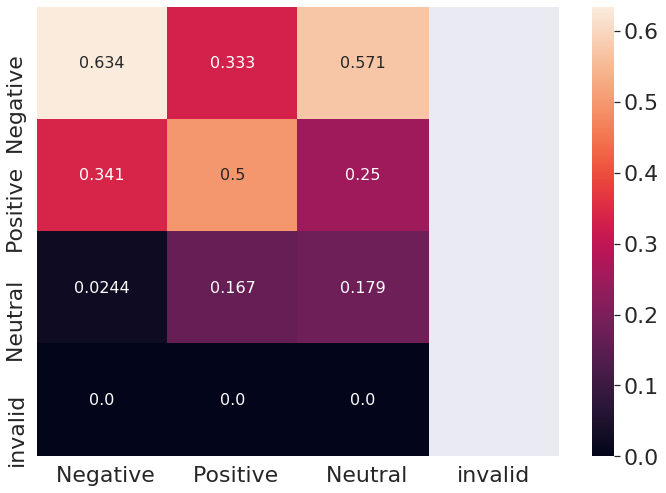

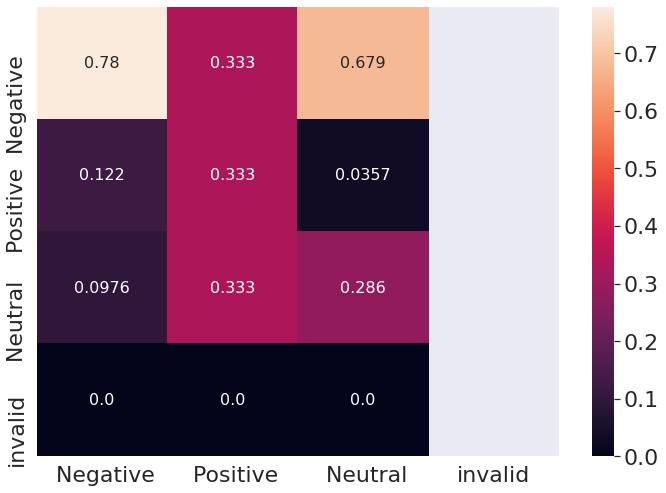

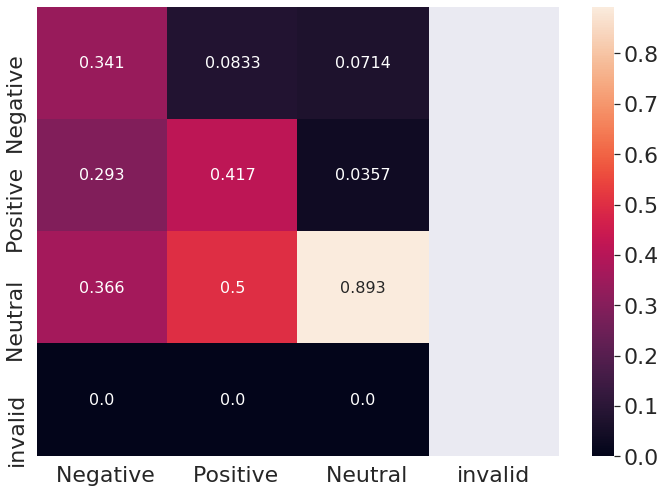

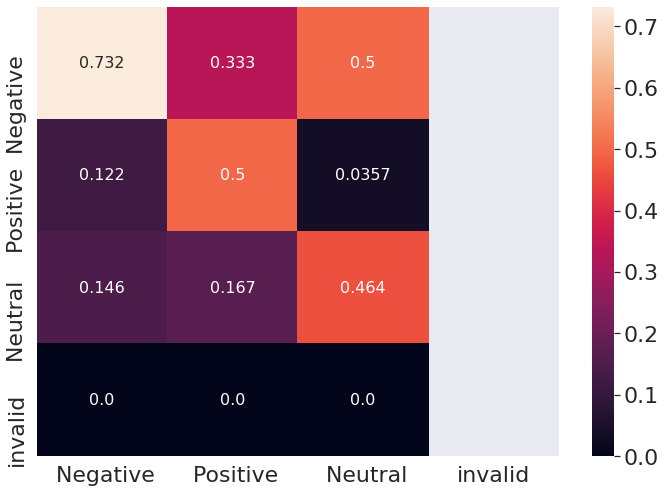

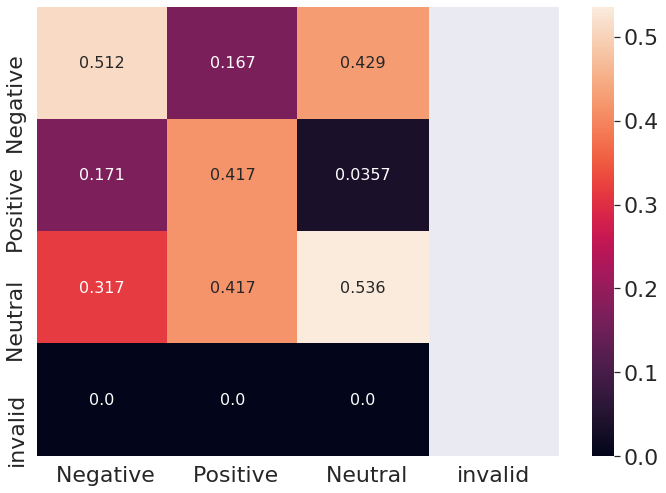

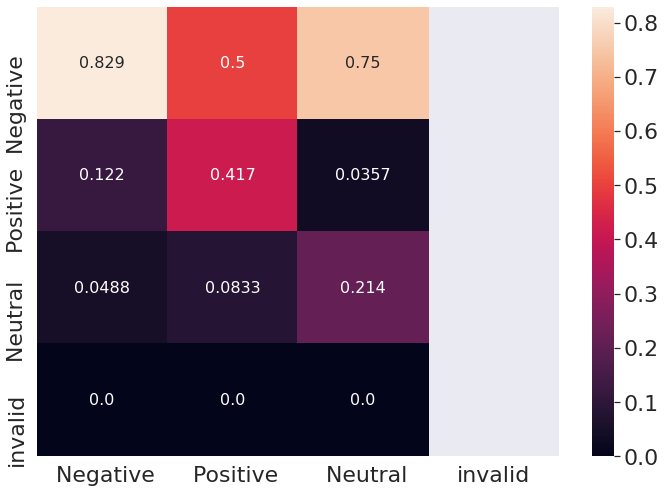

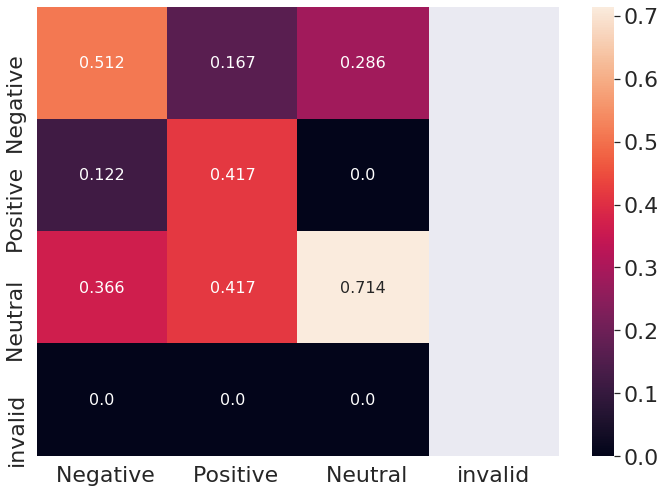

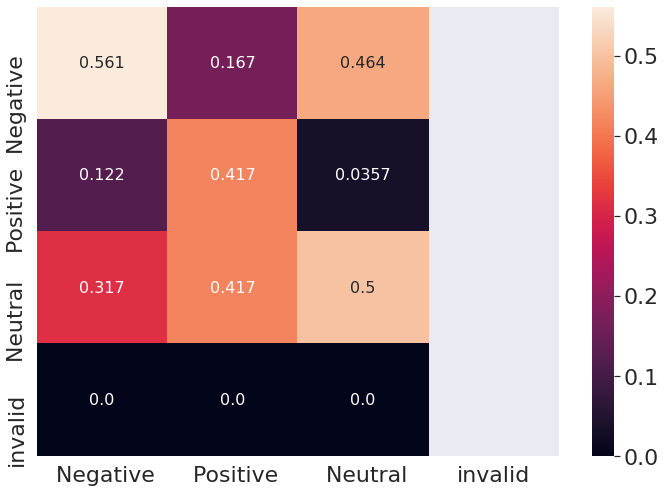

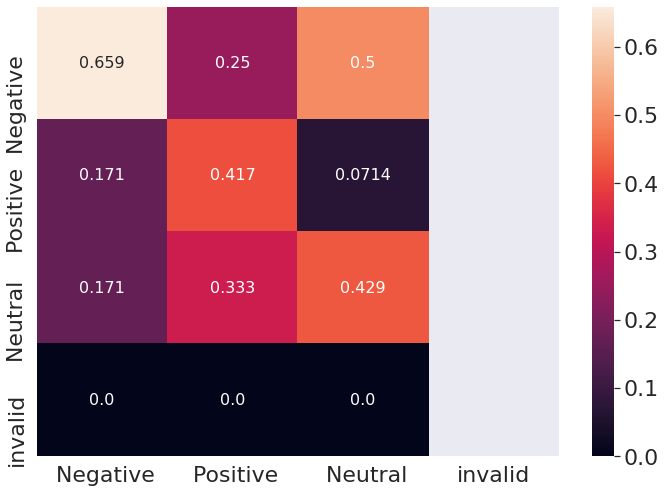

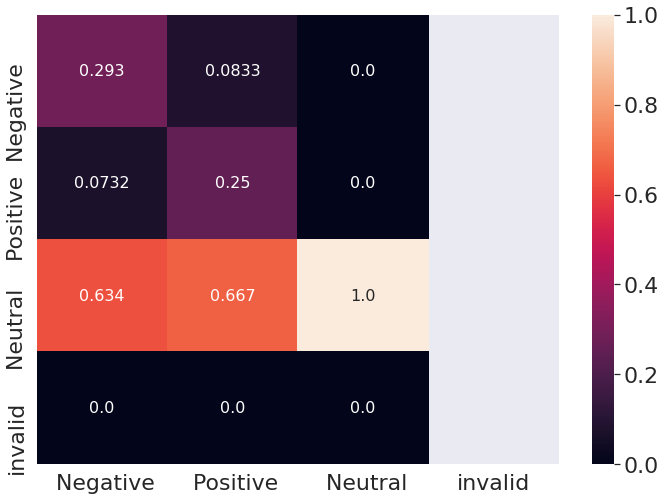

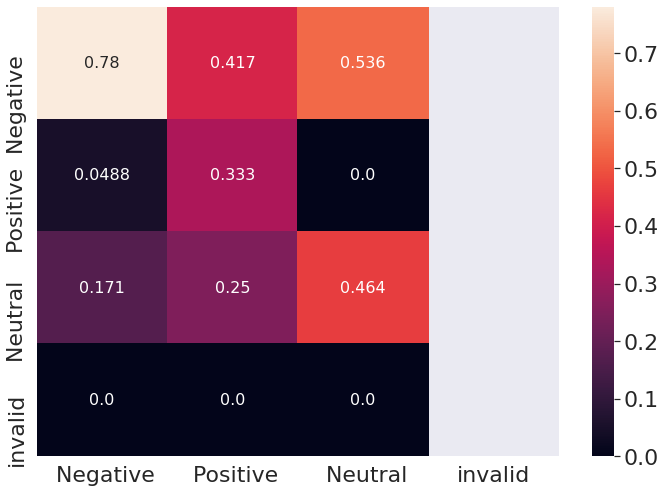

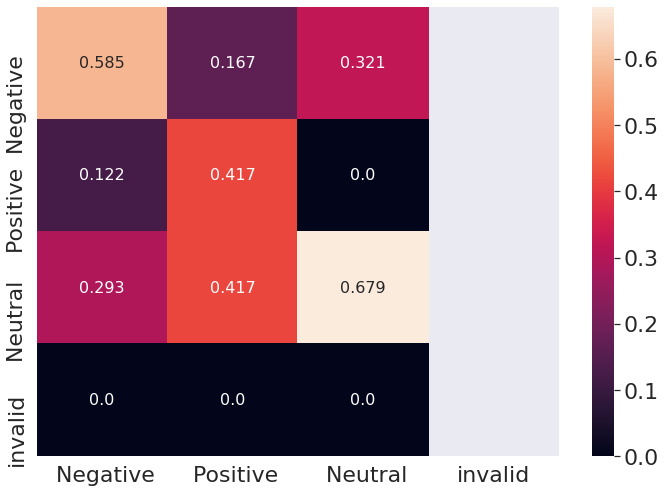

In [13]:
%matplotlib notebook
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import pandas as pd
import random

pd.options.display.max_rows = 4000
plt.ion()

#medium
#powers = [1/4, 1/2, 1, 2, 4]
powers = [1]
for pow in powers:
  model = train(train_objs,
                "yelp", #fine tuning with Twitter conversations but this labels dictionary for confusion matrix is better
                validation_set=templates,
                validation_labels=answers,
                labels_dict=label_dict,
                lr=pow*(2e-5),
                epochs=20,
                batch_size=5,
                gpt2_type="gpt2-medium",
                max_seq_len=1024,
                output_dir="/content/drive/My Drive/projects/multilabel_all_questions/",
                output_prefix=f"demo_Q2_{pow}",
                save_model_on_epoch=True,
                validation_file=f"Q2_demo_{pow}")

# Yelp-2 transfer validation



In [15]:
import pickle
import random
from transformers import AutoConfig
from transformers import AutoTokenizer, GPT2Tokenizer
from transformers import AutoModelWithLMHead

labels_dict_neutral = {
    "all_values":{
        1: " Negative",
        2: " Negative",
        3: " Neutral",
        4: " Positive",
        5: " Positive",
        8: " Positive",
        10: " Negative",
        6: " Neutral"
    },
    "bucketed_labels":{
        1: " Negative",
        2: " Negative",
        3: " Neutral",
        4: " Positive",
        5: " Positive",
        8: " Positive",
        10: " Negative",
        6: " Neutral"
    },
    "baseline_accuracy": 0.333
}



def yelp_predict(labels_dict, prompts, answers, count):

    def load_model():
      """Creates a model and loads in weights for it."""
      config = AutoConfig.from_pretrained('gpt2-medium')

      model = AutoModelWithLMHead.from_pretrained(
          f'/content/drive/My Drive/projects/multilabel_all_questions/demo_Q2_1-{count}.pt',
          config=config
      )
      
      return model

    model = load_model()

    tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
    model.to('cuda')
    model.eval()

    pred = predict(prompts, 
          tokenizer,
          model,
          json_file_out=f'yelp_dummy_{count}.jsonl',
          labels=answers,
          labels_dict=labels_dict_neutral,
          foreign_data=True)

    return pred

In [16]:
preds = []
learning_rate_results = []
loss_lst = []

In [17]:
import pickle
accuracies = []

#you might have to adjust the path to "randomly_sampled_validation.txt"
#which is in the root folder of the repository

with open("randomly_sampled_validation.txt", 'rb') as f:
    answers, prompts = pickle.load(f)
answers = answers[:1500]
prompts = prompts[:1500]

for count in range(20):
  pred = yelp_predict(labels_dict_neutral, prompts, answers, count)
  preds.append(pred)
  learning_rate_results.append(float(pred["accuracy"]))
  loss_lst.append(float(pred["validation_loss"]))

/usr/local/lib/python3.6/dist-packages/transformers/models/auto/modeling_auto.py:852: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


accuracy: 0.66
accuracy: 0.6753333333333333
accuracy: 0.6753333333333333
accuracy: 0.6753333333333333
accuracy: 0.6753333333333333
accuracy: 0.6753333333333333
accuracy: 0.6753333333333333
accuracy: 0.6753333333333333
accuracy: 0.6753333333333333
accuracy: 0.6813333333333333
accuracy: 0.678
accuracy: 0.7786666666666666
accuracy: 0.7
accuracy: 0.8533333333333334
accuracy: 0.76
accuracy: 0.7673333333333333
accuracy: 0.7666666666666667
accuracy: 0.294
accuracy: 0.3566666666666667
accuracy: 0.21266666666666667


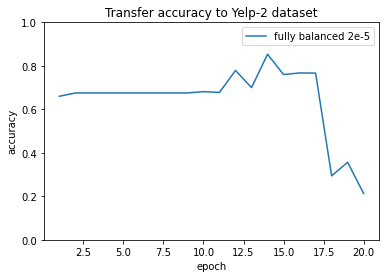

In [3]:
%matplotlib notebook
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import json

x_ticks = [count for count in range(1,21)]

line1 = plt.plot(x_ticks, learning_rate_results, label="fully balanced 2e-5")


#y_ax = np.arange(0,1,.1)
#plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim([0,1])
plt.title("Transfer accuracy to Yelp-2 dataset")
plt.legend()
plt.show()

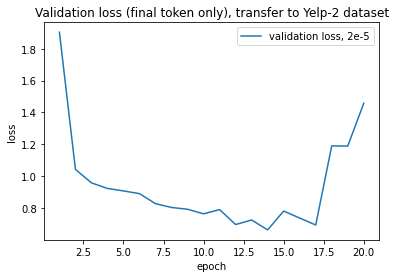

In [4]:
%matplotlib notebook
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import json


x_ticks = [count for count in range(1,21)]

# validation run in another notebook
linehalf = plt.plot(x_ticks, loss_lst, label="validation loss, 2e-5")

plt.xlabel("epoch")
plt.ylabel("loss")
#plt.ylim([0,1])
plt.title("Validation loss (final token only), transfer to Yelp-2 dataset")
plt.legend()
plt.show()